# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


from fastai.vision import *

In [2]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [4]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [6]:
doc(get_transforms)

In [5]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [6]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [7]:
data = get_data(224, bs, 'zeros')

In [10]:
data.train_ds[0]

(Image (3, 224, 224), Category Siamese)

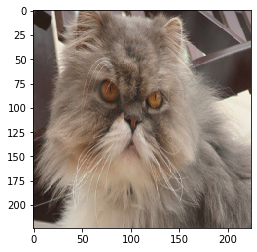

In [16]:
x, y = data.train_ds[1000]
# x.show??
plt.imshow(image2np(x.data)) # (224, 224, 3)

In [14]:
show_image??

In [17]:
data.train_ds[1000][0].show

<bound method Image.show of Image (3, 224, 224)>

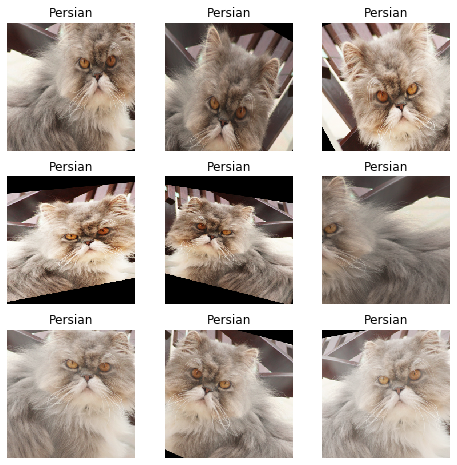

In [18]:
def _plot(i,j,ax):
    x,y = data.train_ds[1000]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [13]:
get_data?


In [19]:
data = get_data(224,bs)

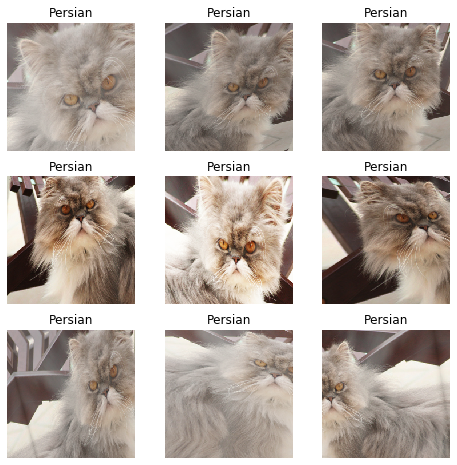

In [20]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [23]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

20

In [24]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.460707,1.245067,0.297023,02:36
1,1.448835,0.348938,0.083221,02:33
2,0.899757,0.287018,0.077131,02:33


In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

In [19]:
data = get_data(352,bs)
learn.data = data

In [20]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.606880,0.248523,0.054127,01:08
1,0.565766,0.252618,0.048714,01:05


In [21]:
learn.save('352')

## Convolution kernel

In [26]:
data = get_data(352,16)

In [27]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category staffordshire_bull_terrier

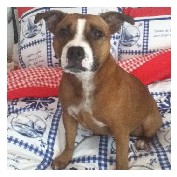

In [32]:
idx=200
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [33]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [34]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [35]:
k.shape

torch.Size([1, 3, 3, 3])

In [36]:
t = data.valid_ds[200][0].data; t.shape

torch.Size([3, 352, 352])

In [37]:
t.shape

torch.Size([3, 352, 352])

In [38]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [39]:
edge = F.conv2d(t[None], k)

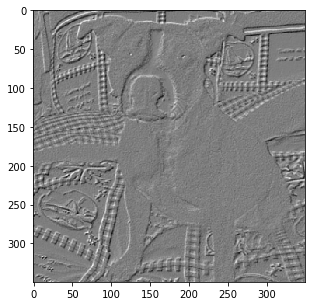

In [40]:
f, ax = plt.subplots(figsize=(5,5))
ax.imshow(image2np(edge[0].data), cmap='binary')

In [66]:
# show_image??

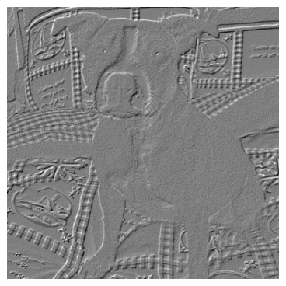

In [41]:
show_image(edge[0], figsize=(5,5));

In [42]:
data.c

37

In [43]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [44]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## Heatmap

In [83]:
learn.model.eval() == learn.model

True

In [45]:
m = learn.model.eval();

In [46]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


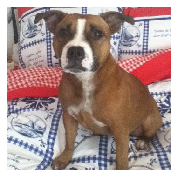

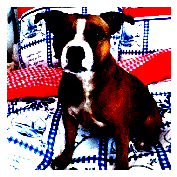

In [47]:
show_image(data.denorm(xb)[0])
show_image(xb[0]) # normalized 

In [48]:
xb[0][0]
xb.shape
data.denorm(xb)[0].max()

tensor([[ 1.3289,  1.2908,  1.1150,  ...,  1.3881,  1.3359,  1.3582],
        [ 1.4076,  1.3864,  1.0563,  ...,  1.3795,  1.4371,  1.2921],
        [ 1.0969,  1.1223,  1.0847,  ...,  1.3344,  1.2509,  1.2448],
        ...,
        [ 1.9767,  1.9756,  1.9782,  ..., -0.2946, -0.1097, -0.1797],
        [ 2.0371,  2.0024,  1.9362,  ..., -0.2901, -0.1503, -0.0708],
        [ 1.9532,  1.9781,  1.9703,  ..., -0.5134, -0.1609, -0.2948]],
       device='cuda:0')

torch.Size([1, 3, 352, 352])

tensor(1.)

In [49]:
from fastai.callbacks.hooks import *

In [51]:
m[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [52]:
m[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=37, bias=True)
  (9): BatchNorm1d(37, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
)

In [53]:
len(m)

2

m[0] is the convolution layers output, m[1] is the fully connected layer to finally get to the probability of 37 classes. we would like to hook into the convolution layer output and store and access its output.

In [54]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [55]:
hook_a,hook_g = hooked_backward()

In [59]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [60]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [63]:
ax.imshow?

In [66]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

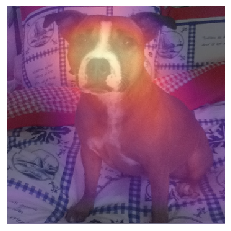

In [67]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [103]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [104]:
mult = (acts*grad_chan[...,None,None]).mean(0)

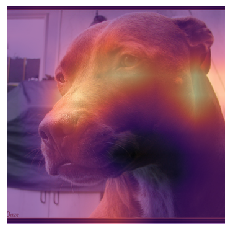

In [105]:
show_heatmap(mult)

In [106]:
fn = path/'../other/bulldog_maine.jpg' #Replace with your own image

In [107]:
x = open_image(fn); x

FileNotFoundError: [Errno 2] No such file or directory: '/projects/da_workspace/szspace/.fastai/data/oxford-iiit-pet/other/bulldog_maine.jpg'

In [108]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [109]:
hook_a,hook_g = hooked_backward()

In [110]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

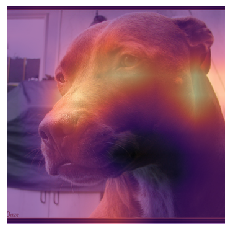

In [111]:
show_heatmap(mult)

In [112]:
data.classes[0]

'Abyssinian'

In [113]:
hook_a,hook_g = hooked_backward(0)

In [114]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

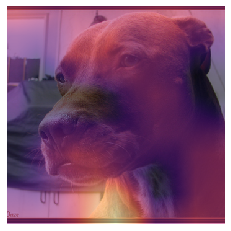

In [115]:
show_heatmap(mult)

## fin